# Suncal API User Manual: Uncertainty in fitting curves

There are two ways to work with uncertainty in fitting curves using suncal. The underlying functions for curve fitting are accessible through the `suncal.curvefit` module.

- **linefit_lsq**: Fit a straight line with uncertainty in y values using least-squares method.
- **linefitYork**: Fit a straight line with uncertainty in x and y values
- **linefit**: Fit a straight line with uncertainty in y and/or x. Chooses between linefit_lsq or linefitYork methods.
- **odrfit**: Fit an arbitrary curve with uncertainty in x and/or y values using Orthogonal Distance Regression

Inspect the docstrings of these methods for information on using them.

The rest of this section describes suncal's curve fitting API using a "measurement model" analagous to the uncertainty propagation `suncal.Model` API.

Use the `suncal.curvefit.Curvefit` measurmeent model, set up with x and y data stored in `suncal.curvefit.Array`.


In [1]:
import suncal
from suncal.curvefit import CurveFit, Array

import numpy as np

## Straight Line Fit

Start by finding the uncertainty in the slope of a line. Here, we'll make up some fake data with some random variation.

In [2]:
a, b = 10, 0.5
uy = 2.0
x = np.arange(50, 105, step=5)
y = a + b * x + np.random.normal(loc=0, scale=uy, size=len(x))

Put the x, y, and uy values into an `Array` instance.

In [3]:
arr = Array(x, y, uy=uy)

Now set up a `CurveFit` model, giving it both the array to work on, and the name of the fit function, in this case 'line'. Just like with uncertainty using `suncal.Model`, run the `calculate` method on `CurveFit` to get a results object.

In [4]:
fit = CurveFit(arr, func='line')
result = fit.calculate()
result

|Parameter   | Nominal   | Standard Uncertainty  |
|-----------|---------|----------------------|
|b           | 0.513  | 0.038              |
|a           | 9.3  | 2.9              |

In Jupyter, the results object displays a table of fit coefficient (slope and intercept for our straight line fit), and uncertainty in each coefficient.
These parameters are attributes of the result object.

In [5]:
result.coeffs

array([0.51257914, 9.29960622])

In [6]:
result.uncerts

array([0.0381385 , 2.92326094])

Formatted reports and plots may be generated from the `report` attribute.

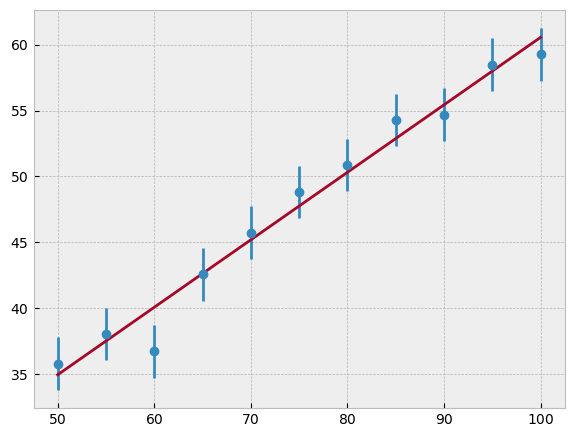

In [7]:
result.report.plot.points(ebar=True)
result.report.plot.fit()

Note that the uncertainty of the slope and uncertainty of the intercept cannot be directly used to predict the uncertainty of a point on the line (due to correlation between parameters). However, the result object provides a `y` function to predict a point on the line, and functions `confidence_band` and `prediction_band` to determine a confidence band (confidence that the fit line passes through the true mean) and a prediction band (uncertainty for a new observation at a given x value). Note these are at k=1. The summary plot shows both these bands.

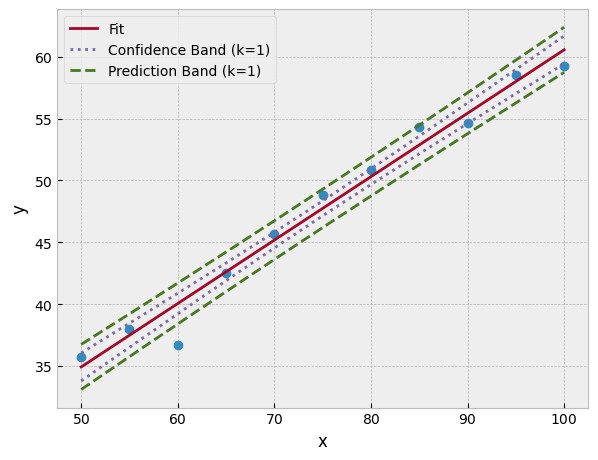

In [8]:
result.report.plot.summary();

To make predictions along the fit line, use `y`,  `confidence_band` and `prediction_band`:

In [9]:
result.y(75)

47.743041451647926

In [10]:
result.confidence_band(x=75)

0.6030226876897884

In [11]:
result.prediction_band(x=75)

1.5514117105062084

## Other fit models

The `func` parameter may be a the name of a commonly used curve, including:

- 'line'
- 'quad'
- 'cubic'
- 'poly'
- 'exp'
- 'decay'
- 'log'
- 'logistic'

It may also be a python callable function for fitting any arbitrary curve, as described below.

## Nonlinear Curves

Fitting a non-linear curve is a similar process, but a function to fit must also be specified. In this case, we fit data points to a normal curve to find the center and standard deviation.

Again we start by making up some fake data with random variation. The data is added to an `Array` instance.

Next, the fit function is defined, in this case, the `norm` function. This callable Python function must take the x values as the first parameter, and the remaining parameters are coefficients to fit.

As an example (although redundant), one could define a straight line fit using

    def line(x, a, b):
        return x*a + b

Send the function and array into CurveFit. In some cases, the algorithm needs an initial guess for the parameters, below it is specified using the `p0` argument to CurveFit.

In [12]:
import scipy

# Make up some fake data
uy = 0.002
x = np.linspace(0,100, num=30)
y = 8 + scipy.stats.norm.pdf(x, loc=20, scale=4) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = Array(x, y, uy=uy)

def norm(x, center, stddev, offst):
    return offst + scipy.stats.norm.pdf(x, loc=center, scale=stddev)

n = CurveFit(func=norm, arr=arr, p0=(18, 5, 8))
result = n.calculate()
result

|Parameter   | Nominal   | Standard Uncertainty  |
|-----------|---------|----------------------|
|center      | 20.004  | 0.080              |
|stddev      | 4.030  | 0.065              |
|offst       | 7.99969  | 0.00037              |

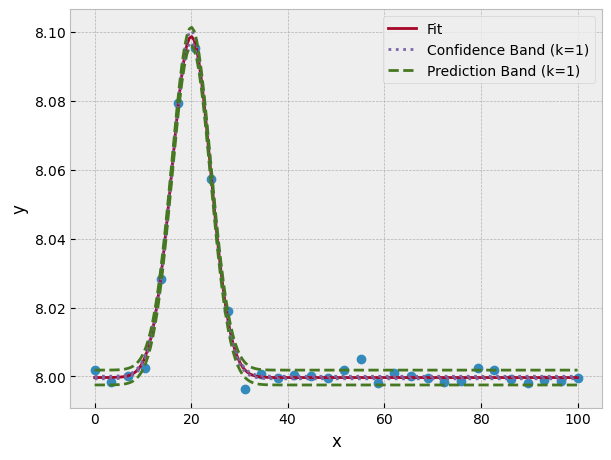

In [13]:
result.report.plot.summary()

## Alternate Uncertainty Methods for Curve Fitting

The above methods all used the covariance matrix resulting from an anlytical least-squares calculation to determine the uncertainty in the fitting coefficients.

For references, see:

[1] Numerical Recipes in C, The Art of Scientific Computing. Second Edition.
    W. H. Press, S. A. Teukolsky, W. T. Vetterling, B. P. Flannery.
    Cambridge University Press. 2002.

[2] York, Evensen. Unified equations for the slope, intercept, and standard
        errors of the best straight line. American Journal of Physics. 72, 367 (2004)
        
[3] Wehr, Saleska. The long-solved problem of the best-fit straight line:
        application to isotopic mixing lines. Biogeosciences. 14, 17-29 (2017)
        
[4] P. T. Boggs and J. E. Rogers, “Orthogonal Distance Regression,” in “Statistical analysis of measurement error models and applications: proceedings of the AMS-IMS-SIAM joint summer research conference held June 10-16, 1989,” Contemporary Mathematics, vol. 112, pg. 186, 1990.


For some unique situations, alternative methods of evaluating uncertainty in curve fits may be used.

### Monte Carlo Unceratinty Method.

The Monte-Carlo method uses the same least-squares curve fitting algorithms as above, but ux and uy are not used in the fitting algorithm itself. Instead, each (x, y) point is sampled over its distribution N times, and N possible fit curves are calculated. The mean and total uncertainty in each parameter is taken from the size-N sample of each fit parameter. The below plot illustrates this approach.

In [14]:
import matplotlib.pyplot as plt

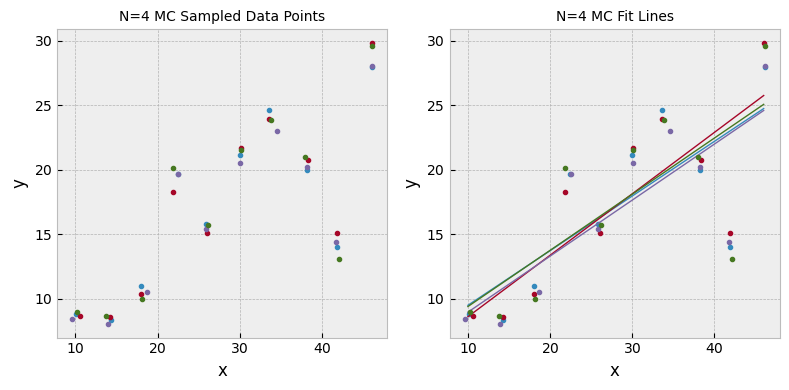

In [15]:
a, b = 3, .5
x = np.arange(10,50,4)
uy = np.linspace(1, 6, num=len(x))
ux = np.linspace(2, .5, num=len(x))
y = a + b * x + np.random.normal(scale=uy, size=len(x))
xx = np.linspace(x.min(), x.max(), num=10)

fig, ax = plt.subplots(ncols=2, figsize=(8,4))

N = 4
for i in range(N):
    xsample = np.random.normal(loc=x, scale=ux/5)
    ysample = np.random.normal(loc=y, scale=uy/5)
    ax[0].plot(xsample, ysample, marker='.', ls='')
    
    # Fit line to this sample of points
    p = np.polyfit(xsample, ysample, deg=1)
    ax[1].plot(xsample, ysample, marker='.', ls='', color='C{}'.format(i))
    ax[1].plot(xx, np.poly1d(p)(xx), lw=1, color='C{}'.format(i))

ax[0].set_title('N={} MC Sampled Data Points'.format(N), fontsize=10)
ax[1].set_title('N={} MC Fit Lines'.format(N), fontsize=10)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
fig.tight_layout()

Monte Carlo fit uncertainty may be calculated using the `monte_carlo` method. The report can generate histograms of the fit parameters as generated by the Monte Carlo simulation.

In [16]:
arr = Array(x, y, ux=ux, uy=uy)
model = CurveFit(arr=arr)
result = model.monte_carlo()
result

|Parameter   | Nominal   | Standard Uncertainty  |
|-----------|---------|----------------------|
|b           | 0.44  | 0.11              |
|a           | 4.8  | 2.5              |

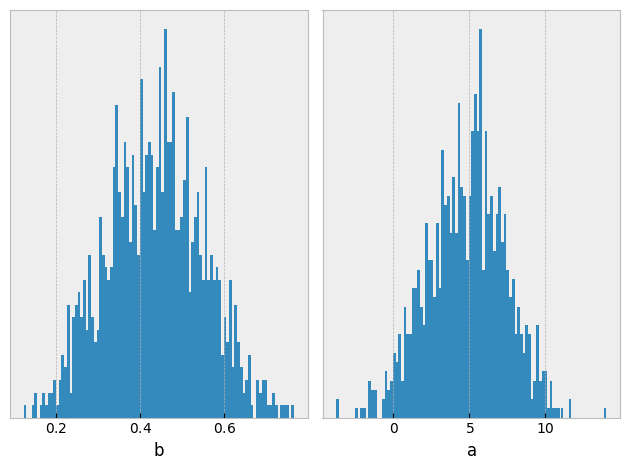

In [17]:
result.report.plot.xhists(bins=100);

### Markov-Chain Monte-Carlo Method

Instead of taking random samples of each measured data point, this method takes random samples in the fit parameter distributions.

1) Baseline uncertainty in each fit parameter is found using least-squares methods described above

2) The space of fit parameters is explored using a random walk based on the probability that the measured data could come from those fit parameters.

3) Mean and uncertainty of each parameter is determined from the distribution of the random walk.

NOTE: This method cannot (currently) handle uncertainty in x or non-uniform uncertainty in y.

[1] C. Elster, B. Toman. "Bayesian uncertainty analysis for a regression model versus
    application of GUM Supplement 1 to the least-squares estimate", Metrologia 48 (2011) 233-240.
    
[2] T. Iamsasri, et. al. "A Bayesian approach to modeling diffraction profiles
    and application to ferroelectric materials." J. Appl. Crystallography (2017). 50, 211-220.

In [18]:
results = fit.markov_chain_monte_carlo()
results

|Parameter   | Nominal   | Standard Uncertainty  |
|-----------|---------|----------------------|
|b           | 0.523  | 0.037              |
|a           | 8.5  | 2.8              |

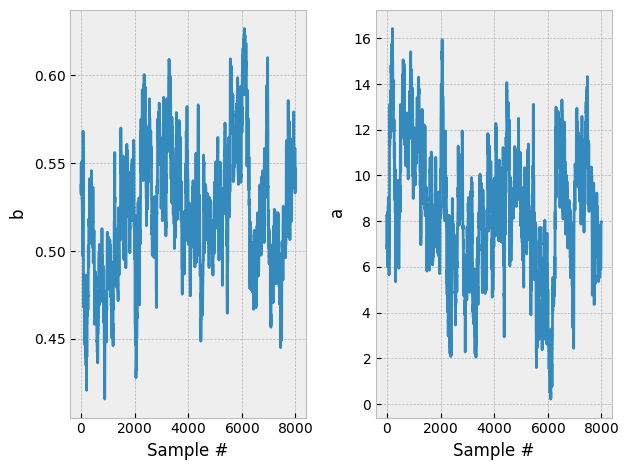

In [19]:
results.report.plot.samples();

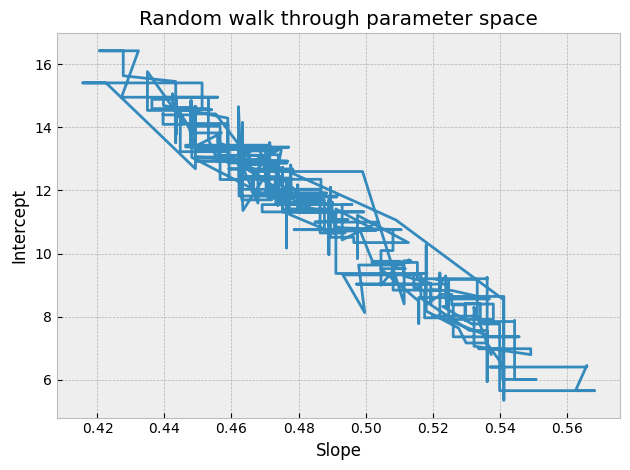

In [20]:
plt.plot(results.samples[:1000,0], results.samples[:1000,1])
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.title('Random walk through parameter space');
plt.tight_layout()

### GUM Method

The GUM assumes a model in the form of $y = f(x1, x2, x3...)$. For curve fitting, we can take the function f to be one of the least-squares curve fit methods and *every* x and y data point to be a single input to the function $f$. To calculate a combined uncertainty, the gradient is numerically computed over all the measured data points, multiplied by the uncertainty of each measurement, and summed together.

$$u_c^2(y)=\sum \left(\frac{\partial f}{\partial x_i}\right)^2 u_{x_i}^2$$

This method assumes all x and y measurements are independent. The plot below illustrates this method, where there are 20 total input variables to the GUM equation.

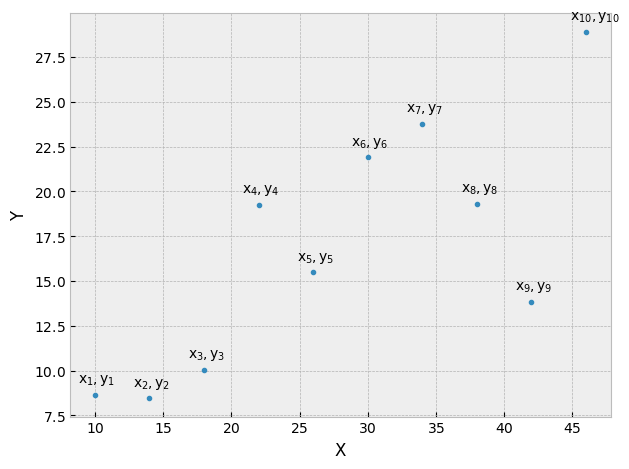

In [21]:
plt.plot(x, y, marker='.', ls='')
for i, (xpoint, ypoint) in enumerate(zip(x, y)):
    plt.text(xpoint-1.2, ypoint+.7, '$x_{{{}}}, y_{{{}}}$'.format(i+1, i+1))
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()

In [24]:
model.calculate_gum()

|Parameter   | Nominal   | Standard Uncertainty  |
|-----------|---------|----------------------|
|b           | 0.43  | 0.11              |
|a           | 4.8  | 2.5              |

### All methods combined

Suncal will compute all 4 methods for comparison using `calculate_all`.

In [23]:
model.calculate_all()

WARNING - MCMC algorithm ignores u(x) != 0
WARNING - MCMC algorithm with non-constant u(y). Using mean.


|Method (k=1)              | b         | a        |
|-------------------------|---------|---------|
|GUM Approximation         | 0.43 ± 0.11 | 4.8 ± 2.5|
|Monte Carlo               | 0.44 ± 0.11 | 4.8 ± 2.5|
|Least Squares             | 0.510 ± 0.090 | 3.0 ± 1.8|
|Markov-Chain Monte Carlo  | 0.440 ± 0.099 | 4.6 ± 3.0|